# Logistic Regression
In this notebook, we implemented and evaluated a Logistic Regression model to predict auto loan default (bad_flag).

In [22]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from preprocessing import load_data, preprocess_data
from model_evaluation import evaluate_models, tune_hyperparameters, feature_importance, threshold_analysis, cross_val_pr_curve, cross_val_roc_curve
import xgboost as xgb
from sklearn.metrics import classification_report
import shap

## Load & Preprocess Data

In [2]:
train_path = "/Users/heba/Desktop/Erdos/Training Dataset A_R-384891_Candidate Attach #1_PresSE_SRF #1142.csv"
eval_path = "/Users/heba/Desktop/Erdos/Evaluation Dataset B_R-384891_Candidate Attach #2_PresSE_SRF #1142.csv"

df_train, df_eval = load_data(train_path, eval_path)
X_train_processed, y_train, X_eval_processed, y_eval, to_drop_corr, cols_to_drop, preprocessor = preprocess_data(df_train, df_eval)

print("Train shape:", X_train_processed.shape)
print("Eval shape:", X_eval_processed.shape)

Train shape: (21348, 28)
Eval shape: (5336, 28)


In [3]:
print("Train class distribution AFTER flip:")
print(y_train.value_counts())

print("Eval class distribution AFTER flip:")
print(y_eval.value_counts())


Train class distribution AFTER flip:
bad_flag
0    20390
1      958
Name: count, dtype: int64
Eval class distribution AFTER flip:
bad_flag
0    5094
1     242
Name: count, dtype: int64


## Logistic Regression

CV Scores: [0.11392968 0.10763889 0.10214552]
Mean CV Score: 0.10790469843336352
Classification Report:               precision    recall  f1-score   support

           0       0.98      0.71      0.82     20390
           1       0.11      0.75      0.19       958

    accuracy                           0.71     21348
   macro avg       0.55      0.73      0.51     21348
weighted avg       0.94      0.71      0.79     21348



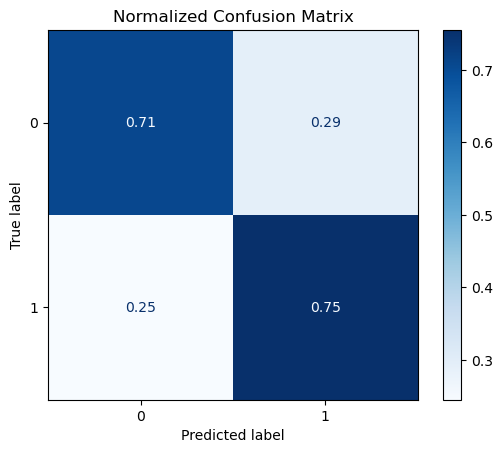

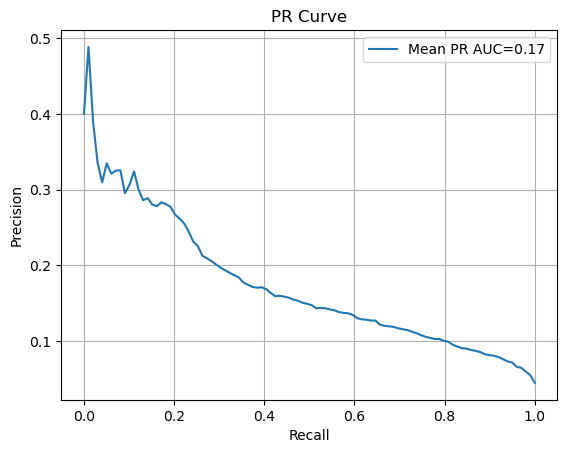

Mean PR AUC: 0.1736


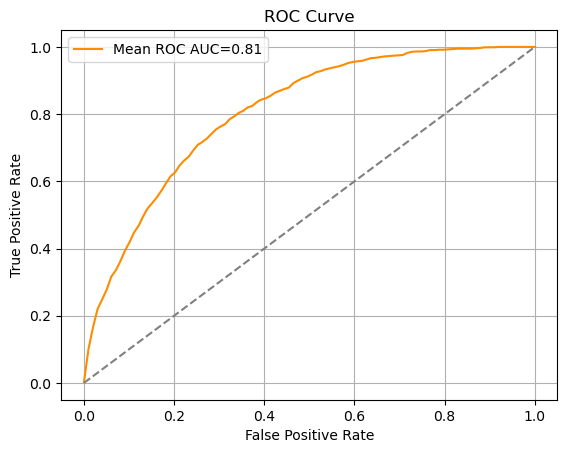

Mean ROC AUC: 0.8063


,precision,recall,f1-score,support
0,0.983962,0.707111,0.822875,20390.000000
1,0.107991,0.754697,0.188946,958.000000
accuracy,0.709247,0.709247,0.709247,0.709247
macro avg,0.545977,0.730904,0.505910,21348.000000
weighted avg,0.944653,0.709247,0.794427,21348.000000


In [6]:
logreg = LogisticRegression(max_iter=5000, class_weight='balanced')
evaluate_models(logreg, X_train_processed, y_train)

Best Params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
CV Scores: [0.11371681 0.1078516  0.10199351]
Mean CV Score: 0.10785397328895217
Classification Report:               precision    recall  f1-score   support

           0       0.98      0.71      0.82     20390
           1       0.11      0.76      0.19       958

    accuracy                           0.71     21348
   macro avg       0.55      0.73      0.51     21348
weighted avg       0.94      0.71      0.79     21348



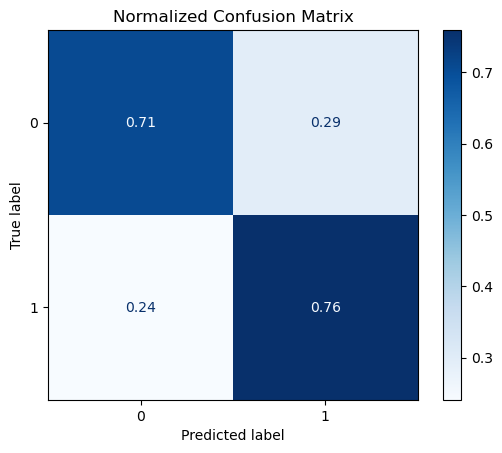

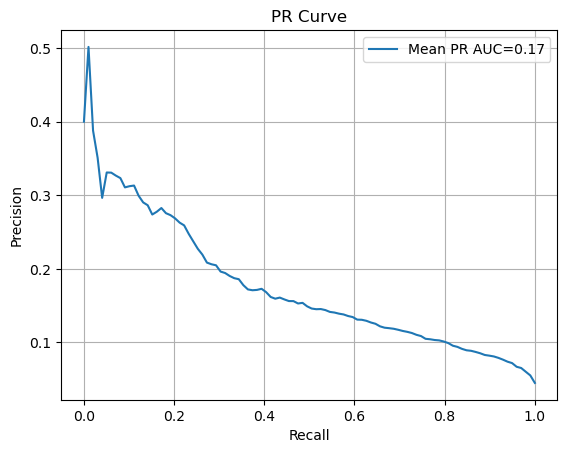

Mean PR AUC: 0.1736


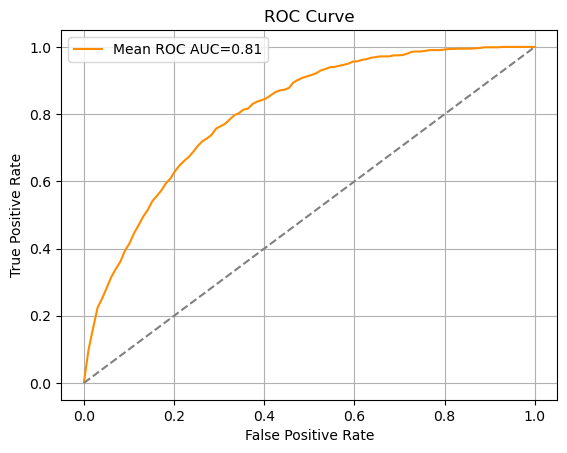

Mean ROC AUC: 0.8065


,precision,recall,f1-score,support
0,0.984192,0.705346,0.821758,20390.000000
1,0.107944,0.758873,0.189003,958.000000
accuracy,0.707748,0.707748,0.707748,0.707748
macro avg,0.546068,0.732109,0.505381,21348.000000
weighted avg,0.944870,0.707748,0.793363,21348.000000


In [7]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # Needed for L1
}

grid = GridSearchCV(LogisticRegression(max_iter=1000, class_weight='balanced'), param_grid, scoring='f1', cv=3)
grid.fit(X_train_processed, y_train)

print("Best Params:", grid.best_params_)
evaluate_models(grid.best_estimator_, X_train_processed, y_train)

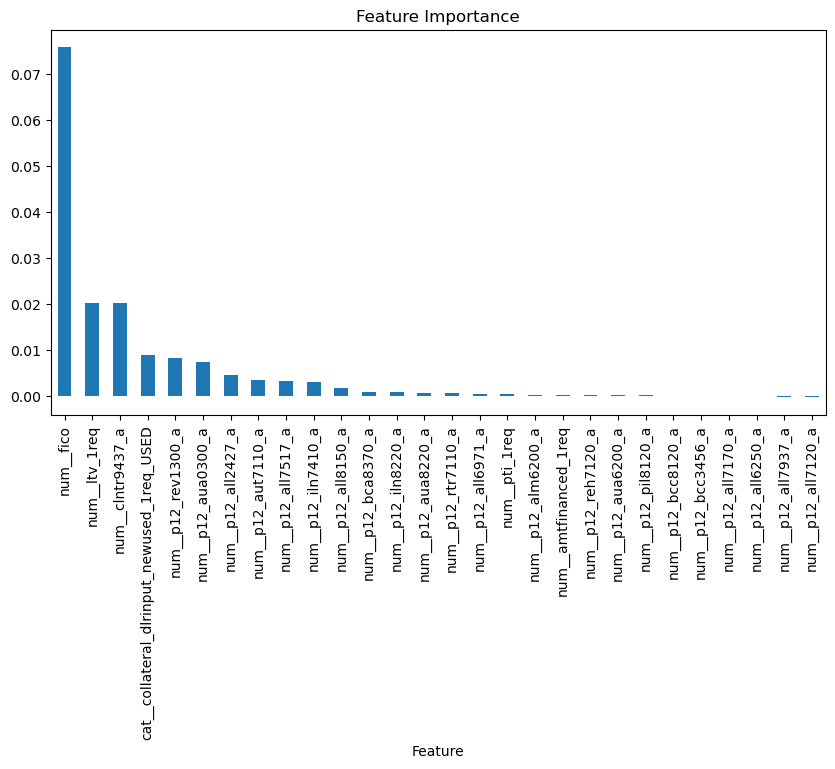

,Feature,Importance
0,num__fico,0.075797
3,num__ltv_1req,0.020299
26,num__clntr9437_a,0.020126
27,cat__collateral_dlrinput_newused_1req_USED,0.009026
11,num__p12_rev1300_a,0.008204
19,num__p12_aua0300_a,0.007438
23,num__p12_all2427_a,0.004522
6,num__p12_aut7110_a,0.003408
14,num__p12_all7517_a,0.003355
10,num__p12_iln7410_a,0.003029


In [8]:
X_named = pd.DataFrame(X_train_processed, columns=preprocessor.get_feature_names_out())

logreg = LogisticRegression(max_iter=5000, class_weight='balanced')
logreg.fit(X_named, y_train)


feature_importance(logreg, X_named, y_train, metric='average_precision')


=== Final Evaluation on Test Set ===
              precision    recall  f1-score   support

           0       0.99      0.53      0.69      5094
           1       0.08      0.88      0.15       242

    accuracy                           0.55      5336
   macro avg       0.54      0.71      0.42      5336
weighted avg       0.95      0.55      0.67      5336



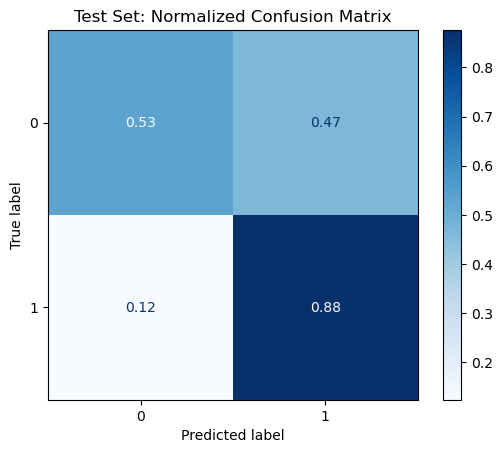

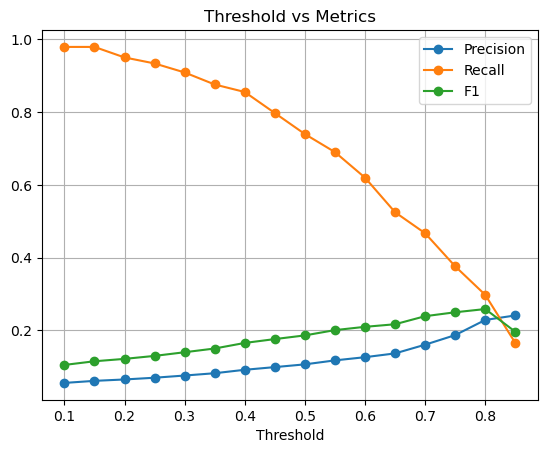

,Threshold,Precision,Recall,F1
0,0.10,0.055387,0.979339,0.104844
1,0.15,0.061051,0.979339,0.114937
2,0.20,0.064898,0.950413,0.121500
3,0.25,0.069689,0.933884,0.129699
4,0.30,0.075705,0.909091,0.139771
5,0.35,0.082043,0.876033,0.150035
6,0.40,0.091512,0.855372,0.165335
7,0.45,0.098873,0.797521,0.175934
8,0.50,0.106421,0.739669,0.186071
9,0.55,0.117358,0.690083,0.200601


In [9]:
import matplotlib.pyplot as plt

X_eval_named = pd.DataFrame(X_eval_processed, columns=preprocessor.get_feature_names_out())

#Predict probabilities and labels
y_eval_proba = logreg.predict_proba(X_eval_named)[:, 1]
y_eval_pred = (y_eval_proba >= 0.35).astype(int)  # Change threshold if you tuned it

#Classification Report
from sklearn.metrics import classification_report, confusion_matrix
print("=== Final Evaluation on Test Set ===")
print(classification_report(y_eval, y_eval_pred))

#Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_eval, y_eval_pred, normalize='true', cmap='Blues')
plt.title("Test Set: Normalized Confusion Matrix")
plt.grid(False)
plt.show()

#Precision-Recall / ROC Curve on Test Set
from model_evaluation import threshold_analysis
threshold_analysis(y_eval, y_eval_proba)


# Interpretability

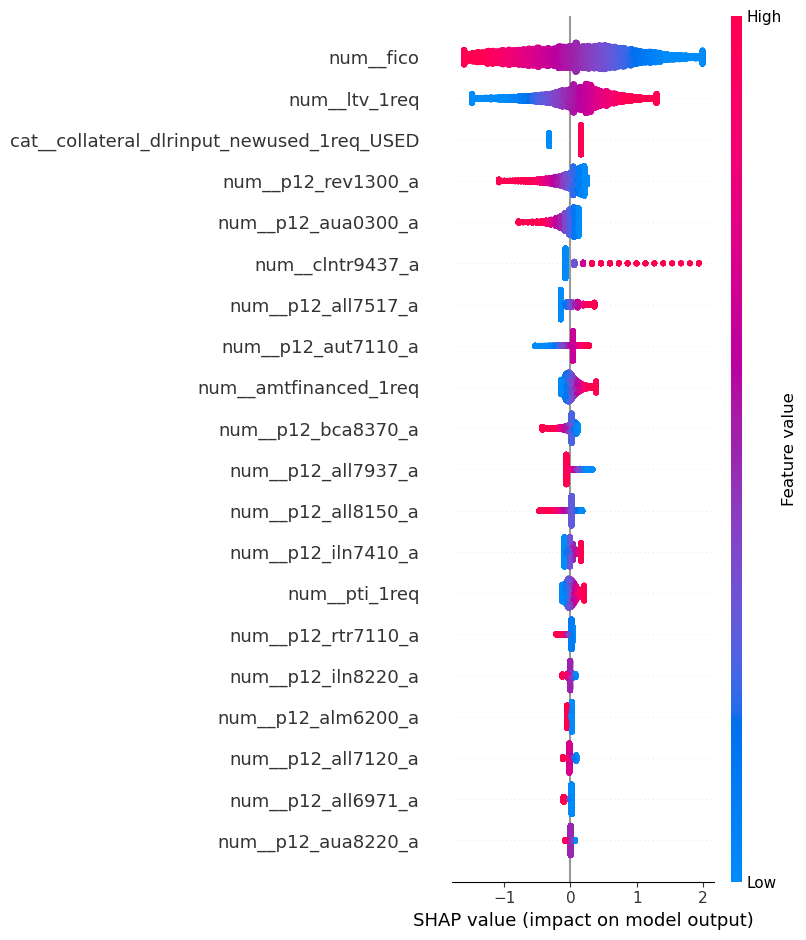

In [23]:
# Use named DataFrame with column names for SHAP plots
X_train_df = pd.DataFrame(X_train_processed, columns=preprocessor.get_feature_names_out())

# Use Independent masker for tabular data
masker = shap.maskers.Independent(X_train_df)

# Create SHAP explainer
explainer = shap.Explainer(logreg, masker)

# Compute SHAP values
shap_values = explainer(X_train_df)

# Plot summary
shap.summary_plot(shap_values, X_train_df)

# Fairness

In [28]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from collections import defaultdict


df_eval_raw = pd.read_csv(eval_path)
sensitive_df = df_eval_raw[['Gender', 'Race']].reset_index(drop=True)


sensitive_df = sensitive_df.iloc[:len(y_pred_test)].reset_index(drop=True)
y_eval = y_eval.reset_index(drop=True)

# Build prediction DataFrame
results_df = pd.DataFrame({
    'true': y_eval,
    'pred': y_pred_test
}).reset_index(drop=True)
results_df = pd.concat([results_df, sensitive_df], axis=1)

# Filter out small or noisy groups
cleaned_results = results_df[(results_df['Race'] != 'Other') & (results_df['Gender'] != 'Undefined')].copy()

# === Gender Metrics ===
gender_metrics = compute_group_metrics(cleaned_results, 'Gender')
gender_eod = compute_eod(gender_metrics[0])
gender_di = compute_disparate_impact(gender_metrics[2])

print("\nGender Fairness (excluding 'Undefined'):")
print("TPR:", gender_metrics[0])
print("FPR:", gender_metrics[1])
print("Approval Rate:", gender_metrics[2])
print("EOD:", gender_eod)
print("DI:", gender_di)

#Race Metrics
race_metrics = compute_group_metrics(cleaned_results, 'Race')
race_eod = compute_eod(race_metrics[0])
race_di = compute_disparate_impact(race_metrics[2])

print("\nRace Fairness (excluding 'Other'):")
print("TPR:", race_metrics[0])
print("FPR:", race_metrics[1])
print("Approval Rate:", race_metrics[2])
print("EOD:", race_eod)
print("DI:", race_di)


# Fairness Metrics 
def compute_group_metrics(results, group_col):
    tpr_by_group = {}
    fpr_by_group = {}
    approval_by_group = {}

    for group in results[group_col].unique():
        group_data = results[results[group_col] == group]
        cm = confusion_matrix(group_data['true'], group_data['pred'], labels=[0, 1])
        tn, fp, fn, tp = cm.ravel() if cm.shape == (2, 2) else (0, 0, 0, 0)

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        approval = group_data['pred'].mean()

        tpr_by_group[group] = round(tpr, 4)
        fpr_by_group[group] = round(fpr, 4)
        approval_by_group[group] = round(approval, 4)

    return tpr_by_group, fpr_by_group, approval_by_group

def compute_eod(metric_dict):
    vals = list(metric_dict.values())
    return round(max(vals) - min(vals), 4)

def compute_disparate_impact(approval_dict):
    rates = list(approval_dict.values())
    return round(min(rates) / max(rates), 4)

#GENDER FAIRNESS
gender_tpr, gender_fpr, gender_approval = compute_group_metrics(results_df, 'Gender')
print("Gender Fairness")
print("TPR:", gender_tpr)
print("FPR:", gender_fpr)
print("Approval Rate:", gender_approval)
print("Equal Opportunity Difference (EOD):", compute_eod(gender_tpr))
print("Disparate Impact (DI):", compute_disparate_impact(gender_approval))

#  RACE FAIRNESS 
race_tpr, race_fpr, race_approval = compute_group_metrics(results_df, 'Race')
print("\n Race Fairness")
print("TPR:", race_tpr)
print("FPR:", race_fpr)
print("Approval Rate:", race_approval)
print("Equal Opportunity Difference (EOD):", compute_eod(race_tpr))
print("Disparate Impact (DI):", compute_disparate_impact(race_approval))


Gender Fairness (excluding 'Undefined'):
TPR: {'Female': np.float64(0.7553), 'Male': np.float64(0.75)}
FPR: {'Female': np.float64(0.2935), 'Male': np.float64(0.3026)}
Approval Rate: {'Female': np.float64(0.3144), 'Male': np.float64(0.3221)}
EOD: 0.0053
DI: 0.9761

Race Fairness (excluding 'Other'):
TPR: {'White': np.float64(0.725), 'Hispanic': np.float64(0.7679), 'Black': np.float64(0.8276), 'Asian': np.float64(0.8)}
FPR: {'White': np.float64(0.3045), 'Hispanic': np.float64(0.2834), 'Black': np.float64(0.3009), 'Asian': np.float64(0.296)}
Approval Rate: {'White': np.float64(0.3228), 'Hispanic': np.float64(0.3068), 'Black': np.float64(0.3231), 'Asian': np.float64(0.3154)}
EOD: 0.1026
DI: 0.9496
Gender Fairness
TPR: {'Undefined': np.float64(0.7), 'Female': np.float64(0.73), 'Male': np.float64(0.75)}
FPR: {'Undefined': np.float64(0.2653), 'Female': np.float64(0.2914), 'Male': np.float64(0.3007)}
Approval Rate: {'Undefined': np.float64(0.2824), 'Female': np.float64(0.3109), 'Male': np.flo

#### Groups such as 'Other' race and 'Undefined' gender were excluded from fairness evaluation due to small sample sizes and ambiguous categorization